<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/src/Passive_Customer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive Feature Selection using Gradient based and Tree based Estimators 

In [26]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [28]:
full_dataset_url = "https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/xtr_profile.csv"
cust_data = pd.read_csv(full_dataset_url)
cust_data = cust_data.loc[:, ~cust_data.columns.str.contains('^Unnamed')]
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              14825 non-null  object 
 1   age                                 14825 non-null  int64  
 2   cust_id                             14825 non-null  object 
 3   became_member_on                    14825 non-null  object 
 4   income                              14825 non-null  float64
 5   days_as_member                      14825 non-null  int64  
 6   Total offer completed               14825 non-null  float64
 7   Total offer received                14825 non-null  float64
 8   Total offer viewed                  14825 non-null  float64
 9   Total transaction                   14825 non-null  float64
 10  offer completed_via_email           14825 non-null  float64
 11  offer completed_via_social          14825

In [29]:
cust_data.select_dtypes(include=[object])

,gender,cust_id,became_member_on
0,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15
1,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09
2,M,e2127556f4f64592b11af22de27a7932,2018-04-26
3,M,389bc3fa690240e798340f5a15918d5c,2018-02-09
4,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11
...,...,...,...
14820,F,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04
14821,M,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13
14822,M,01d26f638c274aa0b965d24cefe3183f,2017-01-26
14823,F,9dc1421481194dcd9400aec7c9ae6366,2016-03-07


In [30]:
# define dataset
gen_split = pd.get_dummies(cust_data['gender'], prefix='is_')
# data['income_in_k'] = data['income']/1000
cust_data = pd.concat([cust_data, gen_split], axis=1)
# data = data.drop('income', axis=1)
cust_data.drop('gender', axis=1, inplace=True)
cust_data.sample(10)

,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,is__F,is__M,is__O
12790,76,ac8acdc4d91945789e009a333ccb4e2c,2016-11-11,80000.0,1476,3.0,3.0,3.0,10.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,2.0,0.0,3.0,3.0,3.0,3.0,1.0,2.0,0.0,228.81,10.000000,200.000000,14.0,14.0,1.00,1.000,22.88,0.006775,1,0,0
11989,67,0b680efe1a0a40788ebb6fb2c587b4a7,2017-08-13,67000.0,1201,0.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,68.04,6.000000,129.600000,0.0,20.0,0.67,0.000,17.01,0.003331,0,1,0
4827,47,fab3921ad34343d28dfb70c6217a1072,2016-02-29,62000.0,1732,5.0,5.0,5.0,8.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0,3.0,5.0,5.0,3.0,2.0,0.0,5.0,3.0,5.0,5.0,3.0,2.0,0.0,121.68,7.000000,187.200000,19.0,19.0,1.00,1.000,15.21,0.004619,0,1,0
3418,62,a42ed50acc4d4b25bca647c9e0b916ad,2016-10-17,33000.0,1501,5.0,6.0,4.0,31.0,5.0,3.0,3.0,5.0,0.0,5.0,6.0,4.0,4.0,5.0,0.0,5.0,1.0,4.0,3.0,3.0,3.0,0.0,3.0,1.0,461.09,11.600000,208.000000,17.0,17.0,0.67,0.833,14.87,0.020653,1,0,0
10867,55,c518abca827b42ff81eb5bc49c455b03,2017-04-04,67000.0,1332,4.0,4.0,4.0,19.0,4.0,2.0,3.0,3.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,0.0,4.0,2.0,3.0,3.0,1.0,3.0,0.0,735.20,11.750000,186.000000,20.0,20.0,1.00,1.000,38.69,0.014264,0,1,0
6007,37,6e81b647b6d84966b63e0d4fc45fc4f6,2016-07-31,62000.0,1579,4.0,4.0,3.0,13.0,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,3.0,3.0,2.0,2.0,0.0,3.0,2.0,3.0,2.0,2.0,1.0,0.0,208.56,9.636364,181.090909,23.0,23.0,0.75,1.000,16.04,0.008233,0,1,0
13634,25,83377d650e4246fa96240dcdfe44e3be,2014-10-28,73000.0,2221,1.0,3.0,3.0,22.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,64.52,10.000000,198.857143,2.0,22.0,1.00,0.333,2.93,0.009905,1,0,0
9500,37,fd50a1eef9554c72aa45a8276804ba9c,2018-01-23,63000.0,1038,0.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,4.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,12.43,9.000000,163.200000,0.0,17.0,0.25,0.000,2.07,0.005780,0,1,0
8987,50,73afdeca19e349b98f09e928644610f8,2016-05-12,86000.0,1659,5.0,5.0,3.0,10.0,5.0,3.0,4.0,5.0,1.0,4.0,5.0,3.0,4.0,5.0,1.0,4.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,0.0,1319.97,10.076923,212.307692,17.0,17.0,0.60,1.000,132.00,0.006028,0,1,0
8048,56,275d6ac7d0c84a43a54d4645daa913fd,2017-10-07,64000.0,1146,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,5.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,8.07,5.714286,144.000000,0.0,15.0,0.40,0.000,2.69,0.002618,0,1,0


In [31]:
cust_data['customer_type'] = "passive"
cust_data.loc[(cust_data['total_view_ratio'] >= 0.6) & (cust_data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
cust_data['customer_type'].value_counts()

active     9637
passive    5188
Name: customer_type, dtype: int64

## Finding set of correlated features

In [32]:
correlated_features = set()
correlation_matrix = cust_data[['is__F', 'is__M', 'is__O', 'age', 'income', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

{'is__M'}

## Set X as Input features and y as target label

In [54]:
X = cust_data[['is__F', 'is__O', 'age', 'income', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = cust_data['customer_type']

## Split Data to Training and Testing Data

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [56]:
#Print the shape of training and test data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (11118, 9)
X_test:  (3707, 9)


## Running RFECV

In [59]:
#RFECV automatically selects the number of features
#Checking with Decision Tree Classifier model
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

pipeline.fit(X_train, y_train)
print('Columns {}'.format(X_train.columns))
print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Feature selection array: ', rfecv.support_)
print('Feature Ranking: ',rfecv.ranking_)

Columns Index(['is__F', 'is__O', 'age', 'income', 'avg_difficulty', 'avg_duration',
       'avg_transaction_amt', 'transactions_per_membership_days',
       'days_as_member'],
      dtype='object')
Optimal number of features: 5
Feature selection array:  [False False False False  True  True  True  True  True]
Feature Ranking:  [4 5 3 2 1 1 1 1 1]


In [60]:
#evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('F1 Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1 Score: 0.718 (0.011)


## Plotting the RFECV curve for the model with best accuracy

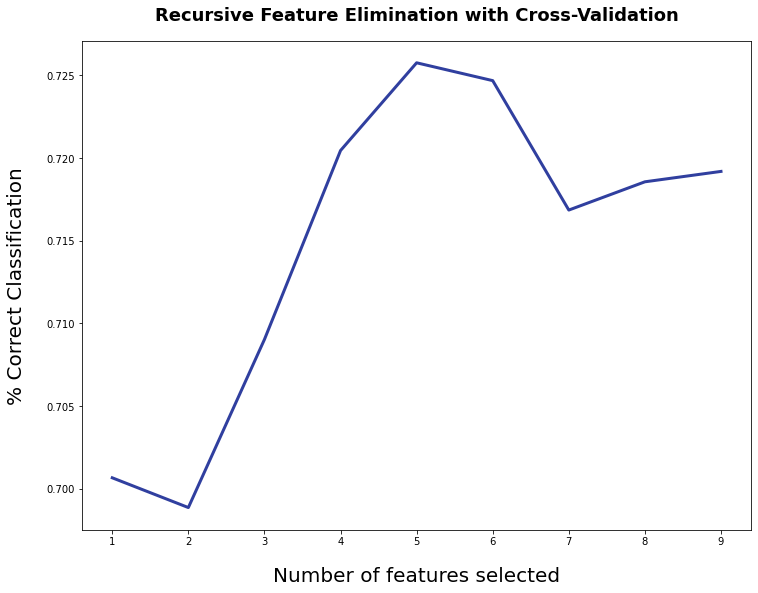

In [61]:
plt.figure(figsize=(12, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=20, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=20, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [62]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

#Dropping the non-required features from training and test data
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[0 1 2 3]


In [63]:
#Print features and feature importance
print("Features: ", X_train.columns)
print("Feature Importance: ", rfecv.estimator_.feature_importances_)

Features:  Index(['avg_difficulty', 'avg_duration', 'avg_transaction_amt',
       'transactions_per_membership_days', 'days_as_member'],
      dtype='object')
Feature Importance:  [0.13822814 0.12094536 0.36193123 0.23761907 0.14127619]


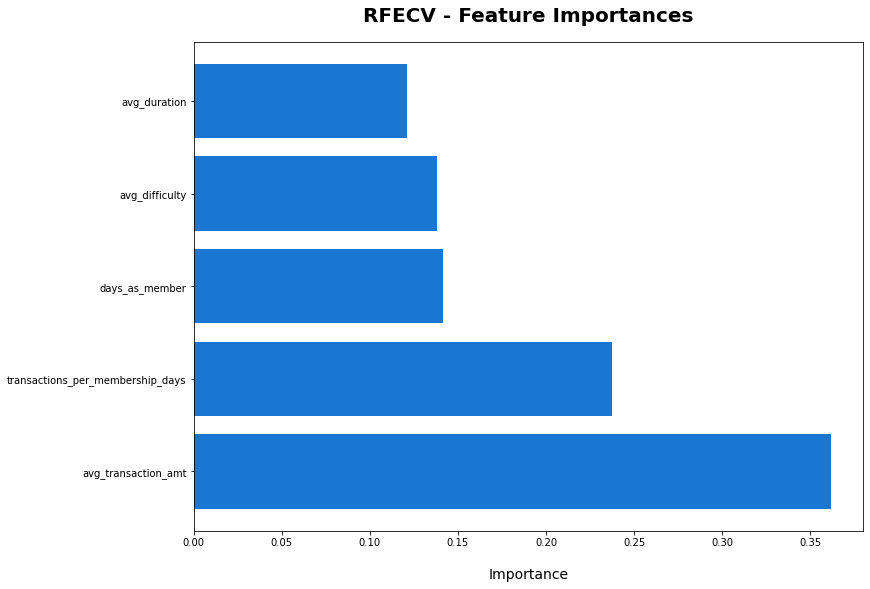

In [64]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 9))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Check if data is balanced

In [65]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (11118, 5)
X_test:  (3707, 5)


In [66]:
y_train.value_counts()

active     7240
passive    3878
Name: customer_type, dtype: int64

In [67]:
#Find percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

active     65.12
passive    34.88
Name: customer_type, dtype: float64

#### The target classes are imbalanced!

### SMOTE

In [68]:
#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

#converting arrays back to Dataframe and Series
X_train = pd.DataFrame(X_oversample, columns=X_train.columns)
y_train = pd.Series(y_oversample, name='y_train')

In [69]:
#check percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

passive    50.0
active     50.0
Name: y_train, dtype: float64

In [70]:
y_train.value_counts()

passive    7240
active     7240
Name: y_train, dtype: int64

In [71]:
#Changing active to 1 and passive to 0 to get f1 score
y_train = y_train.replace(to_replace='active', value= 0)
y_train = y_train.replace(to_replace='passive', value= 1)

y_test = y_test.replace(to_replace='active', value= 0)
y_test = y_test.replace(to_replace='passive', value= 1)

In [72]:
y_train

0        0
1        1
2        0
3        0
4        1
        ..
14475    1
14476    1
14477    1
14478    1
14479    1
Name: y_train, Length: 14480, dtype: int64

## Modeling and Prediction

In [73]:
#Use GridSearchCV to fit selected classifiers to compare the efficiencies of different models
def train_classifier(classifier, hyperparameters, X, y): 
    gridsearch = GridSearchCV(estimator=classifier, param_grid = hyperparameters, cv=5, verbose=1, scoring = 'f1')
    model_train = gridsearch.fit(X, y)
    print(classifier.__class__.__name__)
    print("Mean Accuracy:", round(model_train.score(X, y),4))
    print("F1: ",gridsearch.best_score_)
    return gridsearch.best_estimator_

In [74]:
# Initialize classification algorithms
# LogisticRegression
lor = LogisticRegression(random_state=42)
lor_est = train_classifier(lor,{}, X_train, y_train)

# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc_est = train_classifier(rfc,{}, X_train, y_train)

# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42) 
abc_est = train_classifier(abc,{}, X_train, y_train)

# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42) 
gbc_est = train_classifier(gbc,{}, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression
F1:  0.6786658431758334
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s finished


RandomForestClassifier
F1:  0.7925305343973055
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


AdaBoostClassifier
F1:  0.7378311973468817
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s finished


GradientBoostingClassifier
F1:  0.745927770778987


#### Highest f1 score is obtained for RandomForestClassifier

## Fine Tuning the Model

### Fine tuning RandomForestClassifier and GradientBosstingClassifier with the top set of F1 scores

In [76]:
#Tuning the RandomForestClassifier with hyperparameters to improve the accuracy score
hyperparameters = {'n_estimators': [500],#[100, 120, 300, 500, 800, 1200], #sets the number of decision trees to be used in the forest
                  'max_depth': [30]#[5, 8, 15, 25, 30, None], #sets the max depth of the tree
                  #'min_samples_split': [1,2,5,10,15,100],#, #The minimum number of samples needed before a split
                  #'min_samples_leaf': [1,2,5,10] #The minimum number of samples needed to create a leaf (decision) node
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_est = train_classifier(rfc, hyperparameters, X_train, y_train)
print(rfc_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.5s finished


RandomForestClassifier
F1:  0.7952497096113413
RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)


In [77]:
#Feature importances given by the best estimate RandomForestClassfier
rfc_best_est.feature_importances_

array([0.12989611, 0.13488401, 0.34272181, 0.21592072, 0.17657736])

In [78]:
#Tuning the GradientBoostingClassifier with hyperparameters to improve the accuracy score
#learning_rate; default=0.1; shrinks the contribution of each tree by learning_rates
lr = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

#n_estimators, default=100, number of boosting stages to perform
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#max_depth, default=3, maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree
max_depths = [5, 8, 15, 25, 30, None]

#min_samples_split, default=2, The minimum number of samples required to split an internal node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

#min_samples_leaf, default=1,The minimum number of samples required to be at a leaf node.
min_samples_leaf=np.linspace(0.1, 0.5, 5, endpoint=True)

#max_features{‘auto’, ‘sqrt’, ‘log2’}, default=None, The number of features to consider when looking for the best split:
max_features = list(range(1,X_train.shape[1]))

gb_tuned = GradientBoostingClassifier(random_state=42)
hyperparameters = {'learning_rate': [0.25], 'n_estimators': [200], 'max_depth': [15]}#, 'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}   
gb_best_est = train_classifier(gb_tuned, hyperparameters, X_train, y_train)
print(gb_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


GradientBoostingClassifier
F1:  0.8006991297739328
GradientBoostingClassifier(learning_rate=0.25, max_depth=15, n_estimators=200,
                           random_state=42)


### After fine-tuning GradientBoostClassifier seems to have a higher f1 score than RandomForestClassifier!

## Prediction and Performance of Classifiers




In [79]:
#Print the shape of test data
print(X_test.shape)
print(y_test.shape)

(3707, 5)
(3707,)


### GradientBoostingClassifier

In [80]:
#Passing the test data to the GradientBoostingClassifier estimator
y_pred_gbc = gb_best_est.predict(X_test)
y_pred_gbc

array([0, 0, 0, ..., 0, 0, 0])

####F1 Score

In [96]:
print("Accuracy: {}".format(gb_best_est.score(X_test, y_test)))

Accuracy: 0.7893175074183977


#### Classification Report with F1 score

In [97]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2397
           1       0.72      0.66      0.69      1310

    accuracy                           0.79      3707
   macro avg       0.77      0.76      0.76      3707
weighted avg       0.79      0.79      0.79      3707



#### Confusion Matrix

[[0.85982478 0.14017522]
 [0.33969466 0.66030534]]


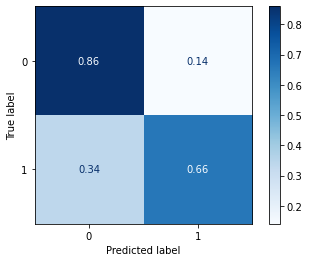

In [83]:
disp = plot_confusion_matrix(gb_best_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

#### F1 Scores have better values for test data!

### RandomForestClassifier

In [84]:
#Passing the test data to the RandomForestClassifier estimator
y_pred_rfc = rfc_best_est.predict(X_test)
y_pred_rfc

array([0, 0, 1, ..., 0, 0, 0])

####F1 Score

In [98]:
print("Accuracy: {}".format(rfc_best_est.score(X_test, y_test)))

Accuracy: 0.794982465605611


#### Classification Report with F1 score





In [86]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2397
           1       0.72      0.69      0.70      1310

    accuracy                           0.79      3707
   macro avg       0.78      0.77      0.77      3707
weighted avg       0.79      0.79      0.79      3707



#### Confusion Matrix

[[0.85398415 0.14601585]
 [0.3129771  0.6870229 ]]


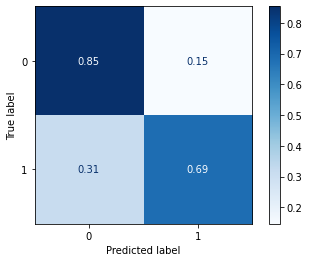

In [87]:
disp = plot_confusion_matrix(rfc_best_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

### AdaBoostClassifier

In [88]:
#Passing the test data to the AdaBoostClassifier estimator
y_pred_abc = abc_est.predict(X_test)
y_pred_abc

array([0, 0, 0, ..., 0, 0, 0])

####F1 Score

In [99]:
print("Accuracy: {}".format(abc_est.score(X_test, y_test)))

Accuracy: 0.7782573509576477


#### Classification Report with F1 score





In [90]:
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2397
           1       0.68      0.70      0.69      1310

    accuracy                           0.78      3707
   macro avg       0.76      0.76      0.76      3707
weighted avg       0.78      0.78      0.78      3707



#### Confusion Matrix

[[0.82227785 0.17772215]
 [0.30229008 0.69770992]]


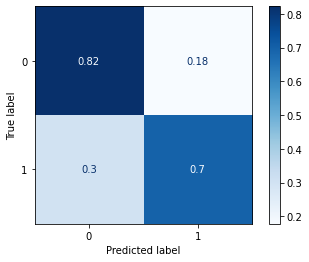

In [91]:
disp = plot_confusion_matrix(abc_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

### Logistic Regression

In [92]:
#Passing the test data to the Logistic Regressor
y_pred_lor = lor_est.predict(X_test)
y_pred_lor

array([0, 0, 0, ..., 1, 0, 1])

####F1 Score

In [100]:
print("Accuracy: {}".format(lor_est.score(X_test, y_test)))

Accuracy: 0.6703533854869167


#### Classification Report with F1 score





In [94]:
print(classification_report(y_test, y_pred_lor))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      2397
           1       0.53      0.66      0.59      1310

    accuracy                           0.67      3707
   macro avg       0.66      0.67      0.66      3707
weighted avg       0.69      0.67      0.68      3707



#### Confusion Matrix 

[[0.67667918 0.32332082]
 [0.34122137 0.65877863]]


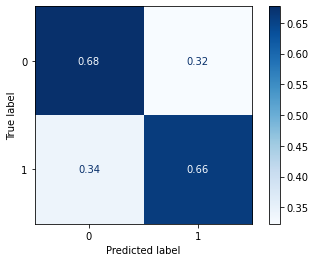

In [95]:
disp = plot_confusion_matrix(lor_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()